In [8]:
!unzip image_and_mask.zip

Streaming output truncated to the last 5000 lines.
  inflating: image_and_mask/Mask/000000047940.png  
  inflating: image_and_mask/Mask/000000232383.png  
  inflating: image_and_mask/Mask/000000457754.png  
  inflating: image_and_mask/Mask/000000056865.png  
  inflating: image_and_mask/Mask/000000268927.png  
  inflating: image_and_mask/Mask/000000414679.png  
  inflating: image_and_mask/Mask/000000028377.png  
  inflating: image_and_mask/Mask/000000127050.png  
  inflating: image_and_mask/Mask/000000503311.png  
  inflating: image_and_mask/Mask/000000161011.png  
  inflating: image_and_mask/Mask/000000170849.png  
  inflating: image_and_mask/Mask/000000520251.png  
  inflating: image_and_mask/Mask/000000239229.png  
  inflating: image_and_mask/Mask/000000144534.png  
  inflating: image_and_mask/Mask/000000560675.png  
  inflating: image_and_mask/Mask/000000009420.png  
  inflating: image_and_mask/Mask/000000139291.png  
  inflating: image_and_mask/Mask/000000407822.png  
  inflating: 

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, random_split, Dataset
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import os
import gc
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

In [16]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

In [17]:
def cleanup_memory():
    """Clean up memory and cache"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

def get_memory_usage():
    """Monitor memory usage"""
    try:
        if torch.cuda.is_available():
            return torch.cuda.memory_allocated() / 1024**3  # GB
        else:
            import psutil
            return psutil.virtual_memory().used / 1024**3  # GB
    except:
        return 0.0

print("Memory management functions loaded!")
print(f"Current memory usage: {get_memory_usage():.2f} GB")


Memory management functions loaded!
Current memory usage: 6.04 GB


In [18]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        return x

class MemoryEfficientSelfAttentionBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=8):
        super(MemoryEfficientSelfAttentionBlock, self).__init__()
        self.reduction_ratio = reduction_ratio
        self.query_conv = nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.pool = nn.AdaptiveAvgPool2d(16)

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        x_pooled = self.pool(x)

        query = self.query_conv(x_pooled)
        key = self.key_conv(x_pooled)
        value = self.value_conv(x_pooled)

        query = query.view(batch_size, -1, 16*16).permute(0, 2, 1)
        key = key.view(batch_size, -1, 16*16)
        value = value.view(batch_size, -1, 16*16)

        attention = torch.bmm(query, key)
        attention = F.softmax(attention, dim=-1)

        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, channels, 16, 16)
        out = F.interpolate(out, size=(height, width), mode='bilinear', align_corners=False)

        return x + self.gamma * out

class SimplifiedSegNet(nn.Module):
    def __init__(self, input_shape, n_classes):
        super(SimplifiedSegNet, self).__init__()
        self.encoder1 = ConvBlock(input_shape[0], 32)
        self.encoder2 = ConvBlock(32, 64)
        self.encoder3 = ConvBlock(64, 128)
        self.encoder4 = ConvBlock(128, 256)

        self.pool = nn.MaxPool2d(2)
        self.bridge = ConvBlock(256, 512)

        self.decoder1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder1_conv = ConvBlock(512, 256)
        self.decoder2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2_conv = ConvBlock(256, 128)
        self.decoder3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder3_conv = ConvBlock(128, 64)
        self.decoder4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder4_conv = ConvBlock(64, 32)

        self.final_conv = nn.Conv2d(32, n_classes, kernel_size=1)
        self.bridge_attention = MemoryEfficientSelfAttentionBlock(512)

    def forward(self, x):
        e1 = self.encoder1(x)
        p1 = self.pool(e1)
        e2 = self.encoder2(p1)
        p2 = self.pool(e2)
        e3 = self.encoder3(p2)
        p3 = self.pool(e3)
        e4 = self.encoder4(p3)
        p4 = self.pool(e4)

        bridge = self.bridge(p4)
        bridge = self.bridge_attention(bridge)

        d1 = self.decoder1(bridge)
        d1 = torch.cat([d1, e4], dim=1)
        d1 = self.decoder1_conv(d1)

        d2 = self.decoder2(d1)
        d2 = torch.cat([d2, e3], dim=1)
        d2 = self.decoder2_conv(d2)

        d3 = self.decoder3(d2)
        d3 = torch.cat([d3, e2], dim=1)
        d3 = self.decoder3_conv(d3)

        d4 = self.decoder4(d3)
        d4 = torch.cat([d4, e1], dim=1)
        d4 = self.decoder4_conv(d4)

        output = self.final_conv(d4)
        return output

print("Model classes loaded successfully!")

Model classes loaded successfully!


In [19]:
class MemoryEfficientDataset(Dataset):  # Added Dataset inheritance!
    def __init__(self, root_path, image_size=256):
        # Fixed path construction
        self.images = sorted([root_path + "/Image/" + i for i in os.listdir(root_path + "/Image/")])
        self.masks = sorted([root_path + "/Mask/" + i for i in os.listdir(root_path + "/Mask/")])

        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.mask_transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor()
        ])

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert("RGB")
        mask = Image.open(self.masks[index]).convert("L")

        img_tensor = self.transform(img)
        mask_tensor = self.mask_transform(mask)

        # Close images to free memory
        img.close()
        mask.close()

        return img_tensor, mask_tensor

    def __len__(self):
        return len(self.images)

print("Dataset class loaded successfully!")


Dataset class loaded successfully!


In [24]:
def train_model
    # Configuration (cleaned up)
    LEARNING_RATE = learning_rate
    BATCH_SIZE = batch_size
    EPOCHS = epochs
    ACCUMULATION_STEPS = 4
    IMAGE_SIZE = image_size  # Fixed: single number, not tuple
    DATA_PATH = data_path
    MODEL_SAVE_PATH = "/Users/spoorthivattem/Desktop/checkpoints/best_model.pth"

    # Device setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Dataset and DataLoader
    train_dataset = MemoryEfficientDataset(DATA_PATH, image_size=IMAGE_SIZE)

    # Split dataset
    generator = torch.Generator().manual_seed(42)
    dataset_length = len(train_dataset)
    train_size = int(0.8 * dataset_length)
    val_size = dataset_length - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size], generator=generator)

    print(f"Training set size: {len(train_dataset)}")
    print(f"Validation set size: {len(val_dataset)}")

    # DataLoaders
    train_dataloader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False,
        drop_last=True
    )

    val_dataloader = DataLoader(
        dataset=val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )

    # Model, optimizer, and criterion
    input_shape = (3, IMAGE_SIZE, IMAGE_SIZE)  # Fixed: use IMAGE_SIZE directly
    n_classes = 1
    model = SimplifiedSegNet(input_shape, n_classes).to(device)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    criterion = nn.BCEWithLogitsLoss()

    # Mixed precision scaler
    scaler = GradScaler() if device.type == 'cuda' else None

    # Training loop
    best_val_loss = float('inf')

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch + 1}/{EPOCHS}")
        print(f"Memory usage before epoch: {get_memory_usage():.2f} GB")

        # Training phase
        model.train()
        train_running_loss = 0
        optimizer.zero_grad()

        for idx, (img, mask) in enumerate(tqdm(train_dataloader, desc="Training")):
            img = img.float().to(device, non_blocking=True)
            mask = mask.float().to(device, non_blocking=True)

            if scaler is not None:
                with autocast():
                    y_pred = model(img)
                    loss = criterion(y_pred, mask) / ACCUMULATION_STEPS

                scaler.scale(loss).backward()

                if (idx + 1) % ACCUMULATION_STEPS == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
            else:
                y_pred = model(img)
                loss = criterion(y_pred, mask) / ACCUMULATION_STEPS
                loss.backward()

                if (idx + 1) % ACCUMULATION_STEPS == 0:
                    optimizer.step()
                    optimizer.zero_grad()

            train_running_loss += loss.item() * ACCUMULATION_STEPS

            # Periodic memory cleanup
            if idx % 10 == 0:
                cleanup_memory()

        # Handle remaining gradients
        if (len(train_dataloader) % ACCUMULATION_STEPS) != 0:
            if scaler is not None:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()

        train_loss = train_running_loss / len(train_dataloader)

        # Validation phase
        model.eval()
        val_running_loss = 0

        with torch.no_grad():
            for idx, (img, mask) in enumerate(tqdm(val_dataloader, desc="Validation")):
                img = img.float().to(device, non_blocking=True)
                mask = mask.float().to(device, non_blocking=True)

                if scaler is not None:
                    with autocast():
                        y_pred = model(img)
                        loss = criterion(y_pred, mask)
                else:
                    y_pred = model(img)
                    loss = criterion(y_pred, mask)

                val_running_loss += loss.item()

        val_loss = val_running_loss / len(val_dataloader)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"New best model saved with validation loss: {best_val_loss:.4f}")

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Memory usage after epoch: {get_memory_usage():.2f} GB")

        # Cleanup after each epoch
        cleanup_memory()

    print("\nTraining completed!")
    print(f"Best validation loss: {best_val_loss:.4f}")
    print(f"Model saved to: {MODEL_SAVE_PATH}")

    return model, MODEL_SAVE_PATH

print("Training function loaded successfully!")

Training function loaded successfully!


In [25]:
def iou_score(pred_mask, orig_mask):
    intersection = torch.logical_and(pred_mask, orig_mask).sum()
    union = torch.logical_or(pred_mask, orig_mask).sum()
    if union == 0:
        return 1.0
    return (intersection.float() / union.float()).item()

def dice_score(pred_mask, orig_mask):
    intersection = torch.sum(pred_mask * orig_mask)
    sum_ = torch.sum(pred_mask) + torch.sum(orig_mask)
    if sum_ == 0:
        return 1.0
    dice = (2. * intersection + 1e-5) / (sum_ + 1e-5)
    return dice.item()

def accuracy_score(pred_mask, orig_mask):
    correct = torch.sum(pred_mask == orig_mask)
    total = pred_mask.numel()
    return (correct.float() / total).item()

def area_error_ratio(pred_mask, orig_mask):
    pred_area = torch.sum(pred_mask)
    orig_area = torch.sum(orig_mask)
    if orig_area == 0:
        return 0.0 if pred_area == 0 else 1.0
    error_area = torch.abs(pred_area - orig_area)
    return (error_area.float() / orig_area.float()).item()

def roc_auc_score(pred_mask, orig_mask):
    try:
        thresholds = torch.linspace(0, 1, 100)
        tprs = []
        fprs = []
        for threshold in thresholds:
            pred_bin = (pred_mask > threshold).float()
            tp = torch.sum((pred_bin == 1) & (orig_mask == 1))
            fp = torch.sum((pred_bin == 1) & (orig_mask == 0))
            tn = torch.sum((pred_bin == 0) & (orig_mask == 0))
            fn = torch.sum((pred_bin == 0) & (orig_mask == 1))

            tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
            tprs.append(tpr.item())
            fprs.append(fpr.item())

        auc = 0
        for i in range(1, len(thresholds)):
            auc += (fprs[i] - fprs[i-1]) * (tprs[i] + tprs[i-1]) / 2
        return abs(auc)
    except:
        return 0.5

def single_image_inference(image, orig_mask, model, device):
    model.eval()
    with torch.no_grad():
        img = image.float().to(device)
        img = img.unsqueeze(0)

        pred_mask = model(img)
        pred_mask = torch.sigmoid(pred_mask)

        img = img.squeeze(0).cpu().detach()
        img = img.permute(1, 2, 0)

        # Denormalize image for display
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = torch.clamp(img, 0, 1)

        pred_mask = pred_mask.squeeze(0).cpu().detach()
        pred_mask = pred_mask.permute(1, 2, 0)
        pred_mask[pred_mask < 0.5] = 0
        pred_mask[pred_mask >= 0.5] = 1

        orig_mask = orig_mask.cpu().detach()
        orig_mask = orig_mask.permute(1, 2, 0)
        orig_mask = (orig_mask > 0.5).float()

        fig = plt.figure(figsize=(12, 4))
        for i in range(1, 4):
            fig.add_subplot(1, 3, i)
            if i == 1:
                plt.imshow(img)
                plt.title("Original Image")
            elif i == 2:
                plt.imshow(pred_mask.squeeze(), cmap="gray")
                plt.title("Predicted Mask")
            else:
                plt.imshow(orig_mask.squeeze(), cmap="gray")
                plt.title("Ground Truth")
            plt.axis('off')
        plt.show()

        iou = iou_score(pred_mask.squeeze(), orig_mask.squeeze())
        dice = dice_score(pred_mask.squeeze(), orig_mask.squeeze())
        accuracy = accuracy_score(pred_mask.squeeze(), orig_mask.squeeze())
        area_error = area_error_ratio(pred_mask.squeeze(), orig_mask.squeeze())
        roc_auc = roc_auc_score(pred_mask.squeeze(), orig_mask.squeeze())

        return iou, dice, accuracy, area_error, roc_auc

def pred_show_image_grid(data_path, model_path, device, image_size=256):
    # Load model
    model = SimplifiedSegNet((3, image_size, image_size), 1).to(device)
    model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))

    # Create dataset and validation split
    dataset = MemoryEfficientDataset(data_path, image_size=image_size)
    generator = torch.Generator().manual_seed(42)
    dataset_length = len(dataset)
    train_size = int(0.8 * dataset_length)
    val_size = dataset_length - train_size
    _, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

    total_iou = 0
    total_dice = 0
    total_accuracy = 0
    total_area_error = 0
    total_roc_auc = 0
    count = 0

    print(f"Evaluating on {len(val_dataset)} validation images...")

    for img, orig_mask in val_dataset:
        iou, dice, accuracy, area_error, roc_auc = single_image_inference(img, orig_mask, model, device)
        total_iou += iou
        total_dice += dice
        total_accuracy += accuracy
        total_area_error += area_error
        total_roc_auc += roc_auc
        count += 1

    avg_iou = total_iou / count
    avg_dice = total_dice / count
    avg_accuracy = total_accuracy / count
    avg_area_error = total_area_error / count
    avg_roc_auc = total_roc_auc / count

    return avg_iou, avg_dice, avg_accuracy, avg_area_error, avg_roc_auc  # ADDED RETURN STATEMENT!

print("Evaluation functions loaded successfully!")

Evaluation functions loaded successfully!


In [27]:
print("="*60)
print("STARTING TRAINING")
print("="*60)

# Run training
model, model_path = train_model(
    data_path="/Users/spoorthivattem/Desktop/Roads/Image_and_masks",
    epochs = 30,  
    learning_rate=0.0015,
    image_size=256,
    batch_size=4
)

print("Training completed successfully!")

STARTING TRAINING
Using device: cpu
Training set size: 77
Validation set size: 20
Total parameters: 8,088,418

Epoch 1/30
Memory usage before epoch: 5.92 GB


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


New best model saved with validation loss: 0.4586
Train Loss: 0.6147
Validation Loss: 0.4586
Memory usage after epoch: 5.86 GB

Epoch 2/30
Memory usage before epoch: 5.86 GB


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


New best model saved with validation loss: 0.4265
Train Loss: 0.4648
Validation Loss: 0.4265
Memory usage after epoch: 5.70 GB

Epoch 3/30
Memory usage before epoch: 5.70 GB


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


New best model saved with validation loss: 0.4203
Train Loss: 0.4367
Validation Loss: 0.4203
Memory usage after epoch: 5.76 GB

Epoch 4/30
Memory usage before epoch: 5.76 GB


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


New best model saved with validation loss: 0.4046
Train Loss: 0.4181
Validation Loss: 0.4046
Memory usage after epoch: 5.82 GB

Epoch 5/30
Memory usage before epoch: 5.82 GB


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


New best model saved with validation loss: 0.3944
Train Loss: 0.4001
Validation Loss: 0.3944
Memory usage after epoch: 5.80 GB

Epoch 6/30
Memory usage before epoch: 5.80 GB


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.66it/s]


New best model saved with validation loss: 0.3721
Train Loss: 0.3834
Validation Loss: 0.3721
Memory usage after epoch: 5.47 GB

Epoch 7/30
Memory usage before epoch: 5.48 GB


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.54it/s]


Train Loss: 0.3727
Validation Loss: 0.3742
Memory usage after epoch: 5.84 GB

Epoch 8/30
Memory usage before epoch: 5.85 GB


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.56it/s]


New best model saved with validation loss: 0.3701
Train Loss: 0.3701
Validation Loss: 0.3701
Memory usage after epoch: 5.94 GB

Epoch 9/30
Memory usage before epoch: 5.94 GB


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.59it/s]


New best model saved with validation loss: 0.3699
Train Loss: 0.3680
Validation Loss: 0.3699
Memory usage after epoch: 5.97 GB

Epoch 10/30
Memory usage before epoch: 5.97 GB


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.57it/s]


New best model saved with validation loss: 0.3628
Train Loss: 0.3675
Validation Loss: 0.3628
Memory usage after epoch: 5.39 GB

Epoch 11/30
Memory usage before epoch: 5.39 GB


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.58it/s]


New best model saved with validation loss: 0.3610
Train Loss: 0.3687
Validation Loss: 0.3610
Memory usage after epoch: 6.07 GB

Epoch 12/30
Memory usage before epoch: 6.07 GB


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.56it/s]


Train Loss: 0.3607
Validation Loss: 0.3637
Memory usage after epoch: 6.21 GB

Epoch 13/30
Memory usage before epoch: 6.21 GB


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.62it/s]


New best model saved with validation loss: 0.3561
Train Loss: 0.3610
Validation Loss: 0.3561
Memory usage after epoch: 6.14 GB

Epoch 14/30
Memory usage before epoch: 6.14 GB


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.56it/s]


Train Loss: 0.3723
Validation Loss: 0.3581
Memory usage after epoch: 5.36 GB

Epoch 15/30
Memory usage before epoch: 5.37 GB


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.57it/s]


Train Loss: 0.3613
Validation Loss: 0.3625
Memory usage after epoch: 5.51 GB

Epoch 16/30
Memory usage before epoch: 5.51 GB


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.59it/s]


Train Loss: 0.3613
Validation Loss: 0.3573
Memory usage after epoch: 5.56 GB

Epoch 17/30
Memory usage before epoch: 5.56 GB


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.56it/s]


New best model saved with validation loss: 0.3540
Train Loss: 0.3602
Validation Loss: 0.3540
Memory usage after epoch: 5.94 GB

Epoch 18/30
Memory usage before epoch: 6.13 GB


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.56it/s]


Train Loss: 0.3601
Validation Loss: 0.3543
Memory usage after epoch: 5.41 GB

Epoch 19/30
Memory usage before epoch: 5.41 GB


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.61it/s]


Train Loss: 0.3600
Validation Loss: 0.3679
Memory usage after epoch: 5.55 GB

Epoch 20/30
Memory usage before epoch: 5.55 GB


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.61it/s]


Train Loss: 0.3613
Validation Loss: 0.3619
Memory usage after epoch: 5.59 GB

Epoch 21/30
Memory usage before epoch: 5.59 GB


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.50it/s]


Train Loss: 0.3609
Validation Loss: 0.3610
Memory usage after epoch: 4.72 GB

Epoch 22/30
Memory usage before epoch: 4.72 GB


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.57it/s]


New best model saved with validation loss: 0.3527
Train Loss: 0.3557
Validation Loss: 0.3527
Memory usage after epoch: 5.48 GB

Epoch 23/30
Memory usage before epoch: 5.50 GB


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.56it/s]


Train Loss: 0.3560
Validation Loss: 0.3633
Memory usage after epoch: 5.77 GB

Epoch 24/30
Memory usage before epoch: 5.77 GB


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.57it/s]


Train Loss: 0.3576
Validation Loss: 0.3543
Memory usage after epoch: 5.79 GB

Epoch 25/30
Memory usage before epoch: 5.79 GB


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.55it/s]


New best model saved with validation loss: 0.3487
Train Loss: 0.3532
Validation Loss: 0.3487
Memory usage after epoch: 5.32 GB

Epoch 26/30
Memory usage before epoch: 5.40 GB


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.59it/s]


Train Loss: 0.3514
Validation Loss: 0.3556
Memory usage after epoch: 5.61 GB

Epoch 27/30
Memory usage before epoch: 5.61 GB


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.59it/s]


New best model saved with validation loss: 0.3461
Train Loss: 0.3550
Validation Loss: 0.3461
Memory usage after epoch: 5.62 GB

Epoch 28/30
Memory usage before epoch: 5.62 GB


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.55it/s]


New best model saved with validation loss: 0.3452
Train Loss: 0.3477
Validation Loss: 0.3452
Memory usage after epoch: 5.67 GB

Epoch 29/30
Memory usage before epoch: 5.67 GB


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.50it/s]


Train Loss: 0.3515
Validation Loss: 0.3540
Memory usage after epoch: 5.45 GB

Epoch 30/30
Memory usage before epoch: 5.45 GB


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.54it/s]

Train Loss: 0.3524
Validation Loss: 0.3490
Memory usage after epoch: 5.67 GB

Training completed!
Best validation loss: 0.3452
Model saved to: /Users/spoorthivattem/Desktop/checkpoints/best_model.pth
Training completed successfully!


STARTING EVALUATION
Evaluating on 20 validation images...


/var/folders/l1/kgd0gw3x2pqg433l5ds6tqnh0000gp/T/ipykernel_6898/246028119.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, 

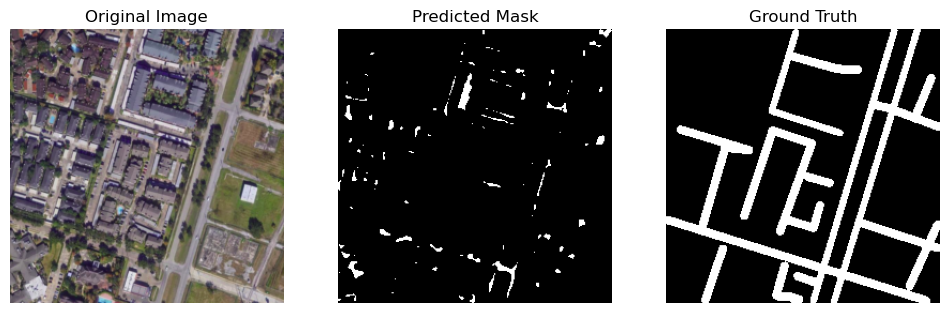

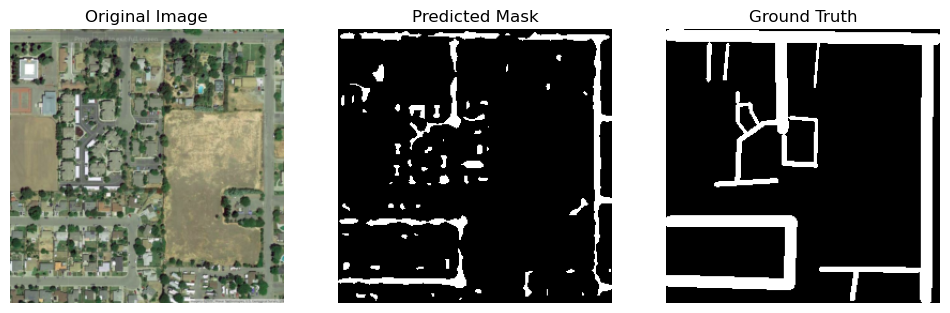

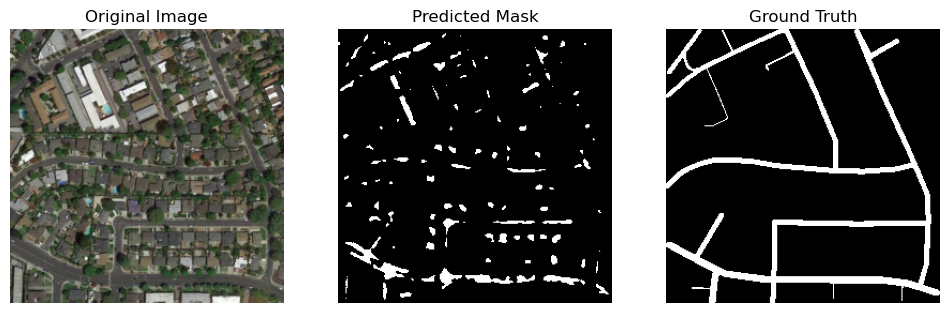

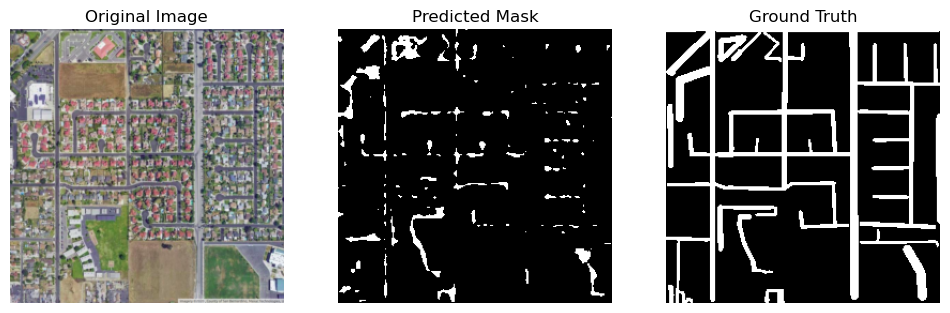

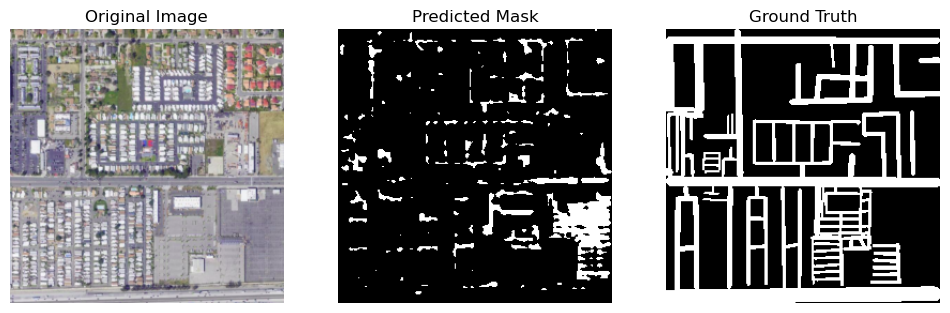

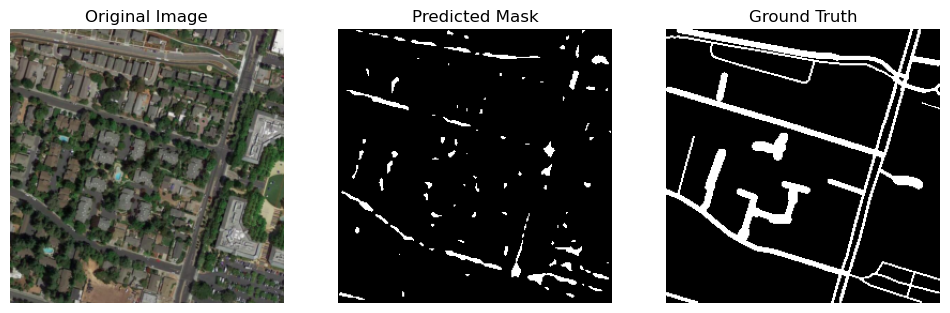

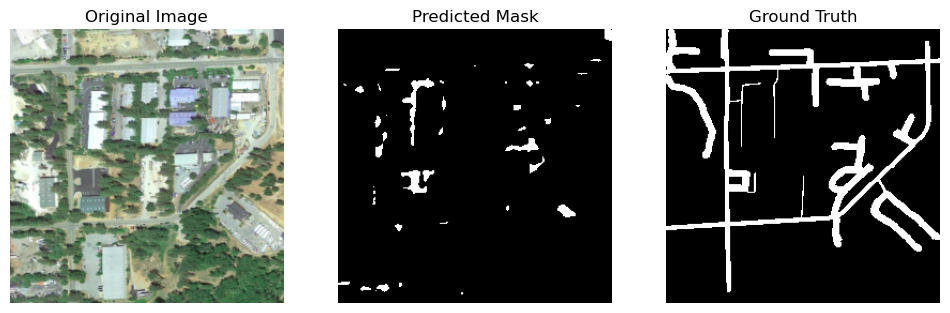

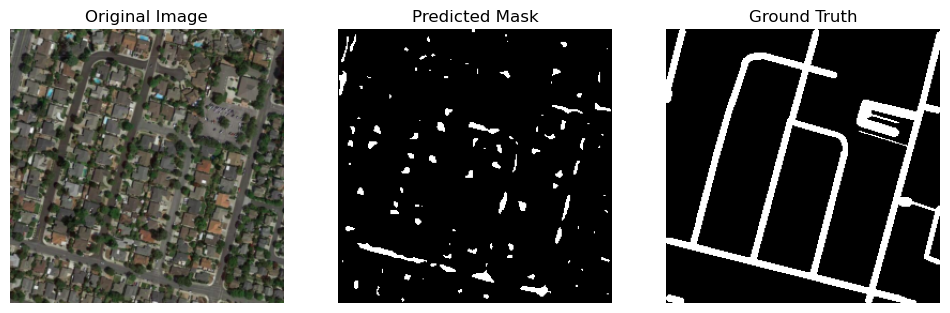

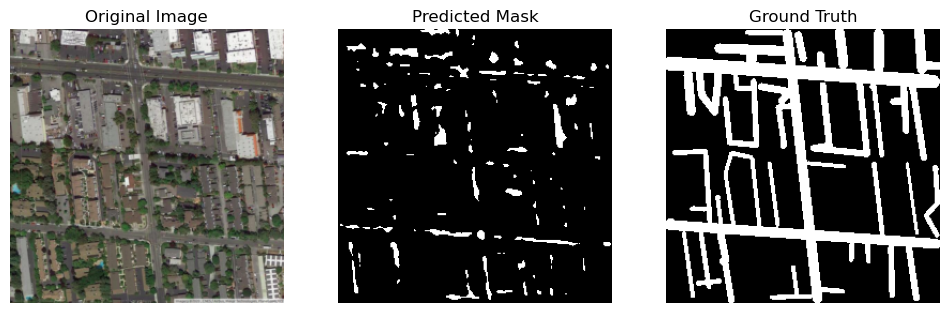

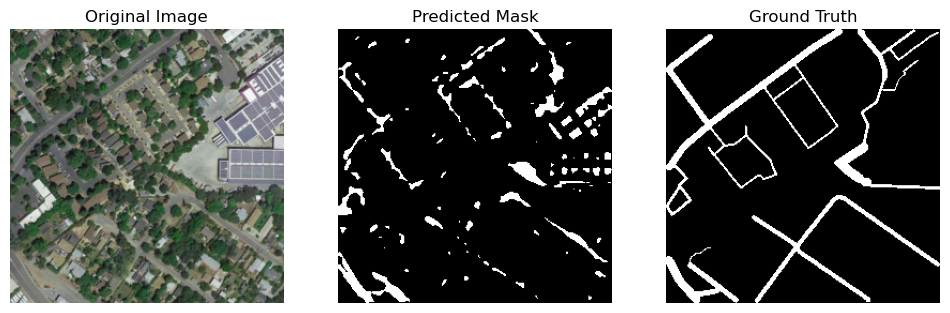

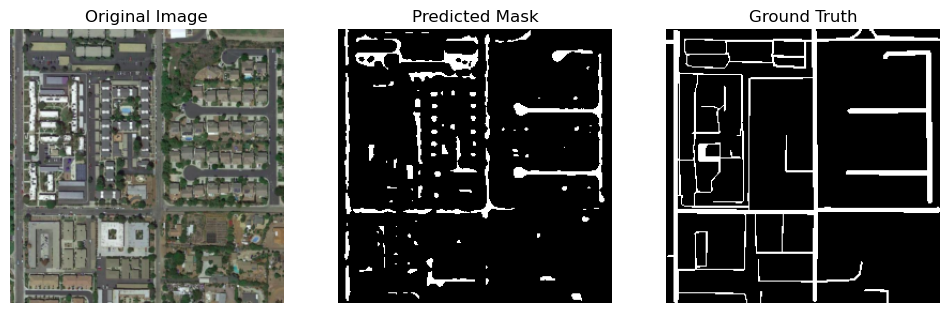

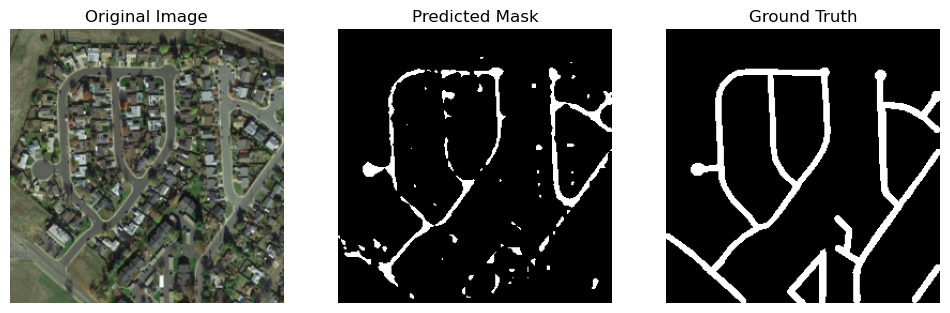

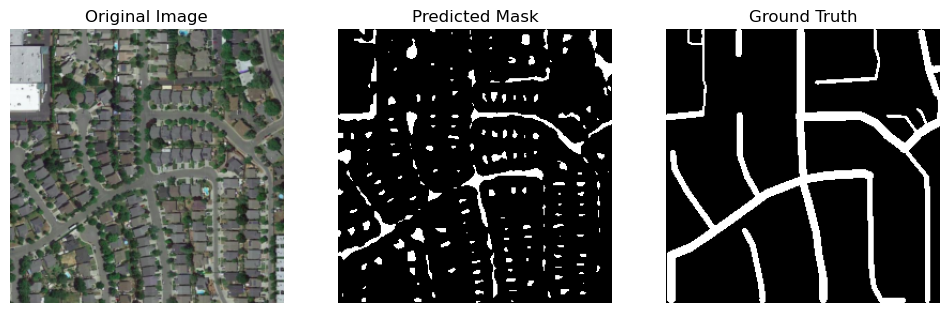

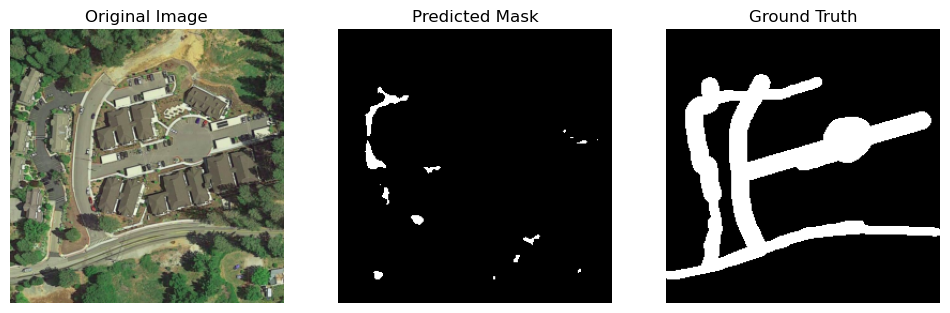

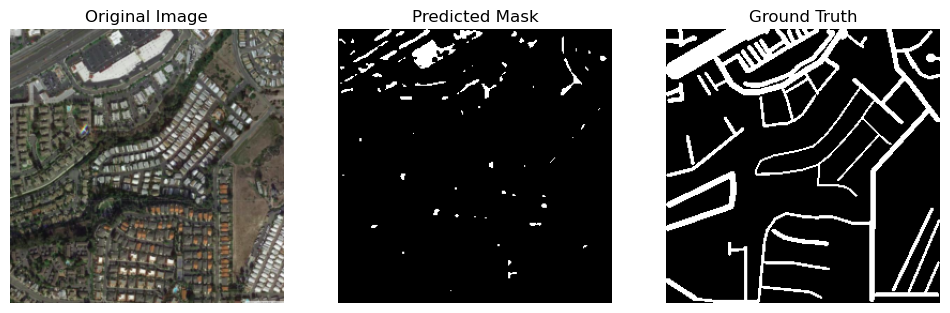

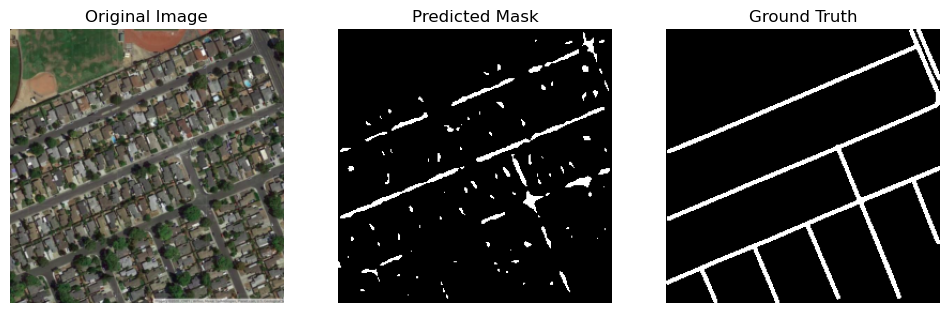

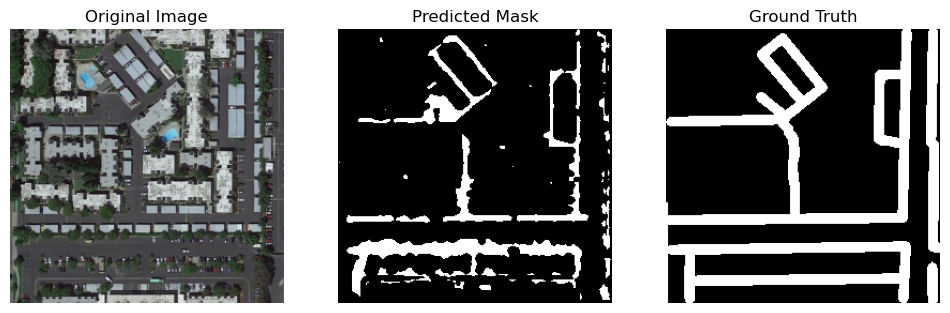

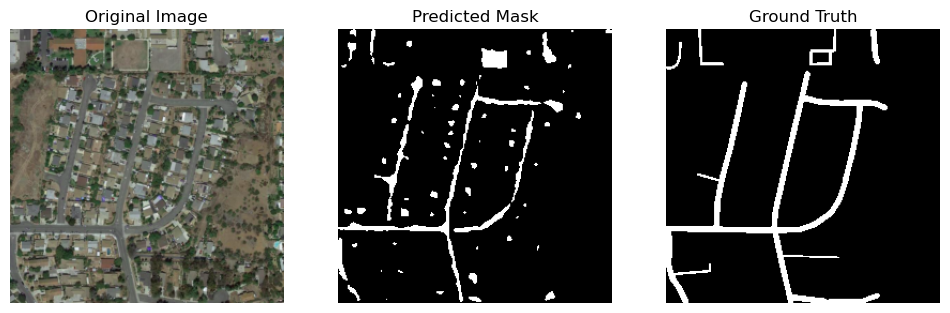

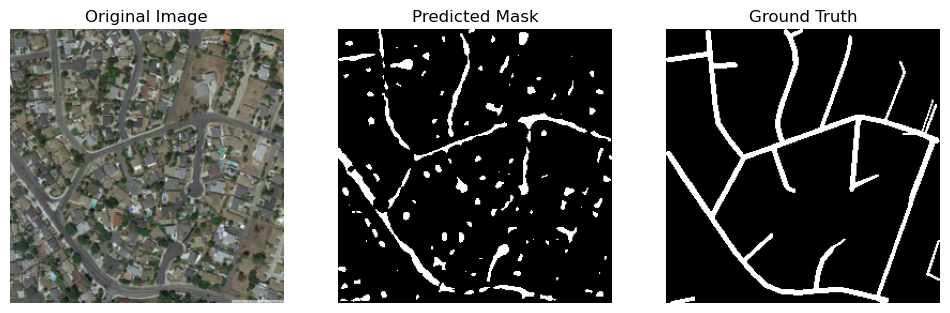

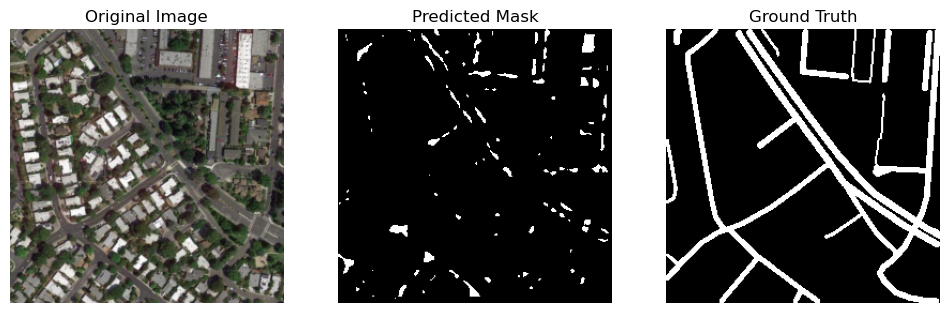


FINAL EVALUATION RESULTS
Average IoU: 0.2279
Average Dice Score: 0.3551
Average Accuracy: 0.8529
Average Area Error Ratio: 0.5766
Average ROC AUC: 0.0038
Evaluation completed successfully!


In [30]:
print("="*60)
print("STARTING EVALUATION")
print("="*60)

# Configuration
DATA_PATH = "/Users/spoorthivattem/Desktop/Roads/Image_and_masks"
MODEL_PATH = "/Users/spoorthivattem/Desktop/checkpoints/best_model.pth"
IMAGE_SIZE = 256

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Run evaluation
avg_iou, avg_dice, avg_accuracy, avg_area_error, avg_roc_auc = pred_show_image_grid(
    DATA_PATH, MODEL_PATH, device, IMAGE_SIZE
)

# Print results
print("\n" + "="*50)
print("FINAL EVALUATION RESULTS")
print("="*50)
print(f"Average IoU: {avg_iou:.4f}")
print(f"Average Dice Score: {avg_dice:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Area Error Ratio: {avg_area_error:.4f}")
print(f"Average ROC AUC: {avg_roc_auc:.4f}")
print("="*50)
print("Evaluation completed successfully!")